In [1]:
%load_ext autoreload
%autoreload 2

import math
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from pathlib import Path
from context import LocalLearning
from LocalLearning.Trainers import CETrainer
from LocalLearning.Regularizers import JFReg
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
import copy
from scipy import stats

plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Cuda available, choose device: {device}")
else:
    device = torch.device('cpu')
    print(f"Cuda unavailable, choose device: {device}")

Cuda available, choose device: cuda


In [3]:
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 300

params = {
        "in_size": 28**2,# MNIST configuration
        "hidden_size": 2000,
        "n": 1.0,
        "p": 3.0,
        "no_classes": 10,
}

In [4]:
train_data = LocalLearning.LpUnitMNIST(
    root="../data/MNIST",
    train=True,
    p=params["p"],
)

dataloader_train = LocalLearning.DeviceDataLoader(
    train_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

test_data = LocalLearning.LpUnitMNIST(
    root="../data/MNIST",
    train=False,
    p=params["p"],
)

dataloader_test = LocalLearning.DeviceDataLoader(
    test_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

/storA/LocalLearning/LocalLearning/src/LocalLearning/LocalLearning.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.dataset.targets = torch.tensor(self.dataset.targets)


In [5]:
class Model(nn.Module):
    
    pSet = {
        "hidden": 2000,
    }
    
    def hidden(x: torch.Tensor):
        pass

class SpecRegModel(Model):
    
    # default parameters
    pSet = {
        "in_size": 32*32*3,
        "hidden_size": 2000,
        "n": 4.5,
        "p": 3.0,
        "no_classes": 10,
    }
    
    def __init__(self, params: dict=None, sigma: float=None, bn=False, dtype: torch.dtype=torch.float32, **kwargs):
        super(SpecRegModel, self).__init__()
        if type(params) != type(None):
            self.pSet["in_size"] = params["in_size"]
            self.pSet["hidden_size"] = params["hidden_size"]
            self.pSet["p"] = params["p"]
            self.pSet["n"] = params["n"]
            self.pSet["no_classes"] = params["no_classes"]
            self.pSet["tau"] = params["tau"]
            
        self.dtype = dtype
        self.flatten = nn.Flatten()
        
        # define linear mapping between input and hidden layer
        # creating the representations
        # same fashion as in KHL3 for optimal control
        self.W = torch.zeros((self.pSet["in_size"], self.pSet["hidden_size"]), dtype=self.dtype)

        # if sigma not explicitely specified, use Keiman He initialisation
        # scheme for ReLU activation functions
        if type(sigma) == type(None):
            sigma = math.sqrt(2 / self.pSet["in_size"])
        
        self.W.normal_(mean=0.0, std=sigma)
        self.W = nn.Parameter(self.W)
        
        self.ReLU = nn.ReLU()
        
        # define second mapping
        modules = []
        if bn: # check whether batch norm was specified or not
            modules.append(nn.BatchNorm1d(self.pSet["hidden_size"]))
        modules.append(
            nn.Linear(self.pSet["hidden_size"], self.pSet["no_classes"], bias=False)
        )
        self.dense = nn.Sequential(*modules)
        
    def hidden(self, x: torch.Tensor):
        x_flat = self.flatten(x)
        return x_flat @ self.W
        
    def forward(self, x: torch.Tensor):
        hidden = self.hidden(x)
        latent_activation = torch.pow(self.ReLU(hidden), self.pSet["n"])
        return self.dense(latent_activation), hidden

In [12]:
class JacobianReg(nn.Module):
    '''
    Implementation from Hoffman et al.
    '''
    def __init__(self, no_projections=None):
        super().__init__()
        
        assert (no_projections == -1) or (no_projections > 0)
        
        self.no_projections=no_projections # number of projections
        if no_projections == -1:
            self.JacReg = self._exact_JacReg
        else:
            self.JacReg = self._projected_JacReg
        
    def _exact_JacReg(self, y: torch.Tensor, x:torch.Tensor):
        '''
        scales terribly and is basically not usable with hidden layer
        '''
        JF = 0
        for i in range(y.size(dim=-1)):
            # define projection tensors
            # in the exact case, these are the canonical basis vectors 
            # of the hidden layer representation
            v = torch.zeros_like(y)
            v[:, i] = 1
            J, = torch.autograd.grad(y, x, 
                                     grad_outputs=v,
                                     retain_graph=True,
                                     create_graph=True,
                                    )
            JF += J.norm(p='fro')**2
        return JF
    
    def _projected_JacReg(self, y: torch.Tensor, x: torch.Tensor):
        # y: Tensor, size=(BATCH_SIZE, HIDDEN_SIZE) - model representation
        # x: Tensor, size=(BATCH_SIZE, INPUT_SIZE) - model input
        BATCH_SIZE, HIDDEN_SIZE = y.size()
        JF = 0
        for _ in range(self.no_projections):
            # sample random vectors on unit sphere
            v = torch.normal(mean=0.0, std=torch.ones_like(y)).to(device=y.device)
            #v = torch.ones_like(y).to(y.device)
            v /= v.norm(p=2, dim=-1)[..., None] 
            
            y = y.flatten()
            Jv, = torch.autograd.grad(y, x,
                                     grad_outputs=v.flatten(),
                                     retain_graph=True,
                                     create_graph=True,
                                    )
            JF += HIDDEN_SIZE*Jv.norm(p=2)**2 / (self.no_projections*BATCH_SIZE)
        return JF
            
    def forward(self, y: torch.Tensor, x: torch.Tensor):
        return self.JacReg(y, x)
        

In [13]:
class Trainer():
    
    sPs = {
        "lambda_JR": 1e-3, # Lagrange Multiplier for Jacobian Regularisation
        "n": 1, # Number of Projections 
    }
    
    def __init__(self,
                 device: torch.device,
                 spectral_ps: sPs=sPs,
                 learning_rate: float=1e-4,
                 no_epochs: int=5,
                 dtype: torch.dtype=torch.float32,
                ):
        
        self.no_epochs = no_epochs
        self.sPs = spectral_ps
        self.gamma = torch.Tensor()
        self.device = device
        self.dtype = dtype
        # training history
        self.ce_history = []
        self.jf_history = []
        # evaluation history
        self.acc_eval = []
        self.jf_score_eval = []
        self.learning_rate = learning_rate
        
        self.JacReg = JacobianReg(self.sPs["n"])
    
    def __call__(self, 
                 trainData: DataLoader,
                 model: SpecRegModel,
                 no_epochs: int=5,
                 testData: DataLoader=None,
                ):
        optimizer = Adam(model.parameters(), lr=self.learning_rate)
        ce_loss_fn = CrossEntropyLoss()
    
        with tqdm(range(1, no_epochs + 1), unit="epoch") as tepoch:
            tepoch.set_description(f"Training time [epochs]")
            for epoch in tepoch:
                
                torch.cuda.empty_cache()
                model.train()
                cumm_ce_loss = 0.0
                cumm_jr_loss = 0.0
                for batch_nr, (features, labels) in enumerate(trainData):

                    # batch preprocessing
                    features = features.to(device)
                    features.requires_grad_()
                    #labels = labels.to(device)
                    
                    # batch optimization
                    optimizer.zero_grad()
                    pred, hidden_state = model(features)
                    JR_loss = self.JacReg(hidden_state, features)
                    ce_loss = ce_loss_fn(pred, labels.to(self.device))
                    loss = ce_loss + self.sPs["lambda_JR"]*JR_loss
                    
                    loss.backward()
                    optimizer.step()
                    # gradient clipping
                    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0, model.pSet["p"])
                    cumm_ce_loss += float(loss)
                    cumm_jr_loss += float(JR_loss)
                    
                    # batch post-processing
                    #features.to('cpu', non_blocking=True)
                    #labels.to('cpu', non_blocking=True)
                
                self.ce_history.append(cumm_ce_loss)
                self.jf_history.append(cumm_jr_loss)
                
                if type(testData) != type(None):
                    model.eval()
                    freq_correct = 0
                    jf_score = 0.0
                    for batch_no, (features, labels) in enumerate(testData):
                        # batch preprocessing
                        features = features.to(self.device)
                        features.requires_grad_()
                        
                        # batch evaluation
                        preds, hidden_state = model(features)
                        preds = torch.argmax(preds, dim=-1)
                        freq_correct += int((torch.abs(preds - labels.to(self.device)) == 0).sum())
                        Jf = self.JacReg(hidden_state, features)
                        jf_score += float(Jf)
            
                    self.acc_eval.append(freq_correct / (len(testData)*testData.batch_size))
                    self.jf_score_eval.append(jf_score)
            
    def get_training_history(self, mode: str="list"):
        if mode == "numpy":
            ce_loss = np.array(self.ce_history)
            jf_loss = np.array(self.jf_history)
            return (ce_loss, jf_loss)
        
        return (self.ce_history, self.jf_history)
    
    def get_eval(self, mode: str="list"):
        if mode == "numpy":
            acc_eval = np.array(self.acc_eval)
            jf_score_eval = np.array(self.jf_score_eval)
            return (acc_eval, jf_score_eval)
        
        return (self.acc_eval, self.jf_score_eval)

In [14]:
pSet = {
        "in_size": 28**2,
        "hidden_size": 2000,
        "n": 4.5,
        "p": 3.0,
        "no_classes": 10,
        "tau": 0,
    }
model = SpecRegModel(params=pSet)
model.to(device)
model.train()

SpecRegModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ReLU): ReLU()
  (dense): Sequential(
    (0): Linear(in_features=2000, out_features=10, bias=False)
  )
)

In [15]:
import copy
model_cpy = copy.deepcopy(model)

In [16]:
jf_reg_params = {
    "lambda_JR": 1e-3,
    "n": 1,
}
jfTrainer = Trainer(device, jf_reg_params, learning_rate=1e-3)
jfTrainer(dataloader_train, model, no_epochs=1000, testData=dataloader_test)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

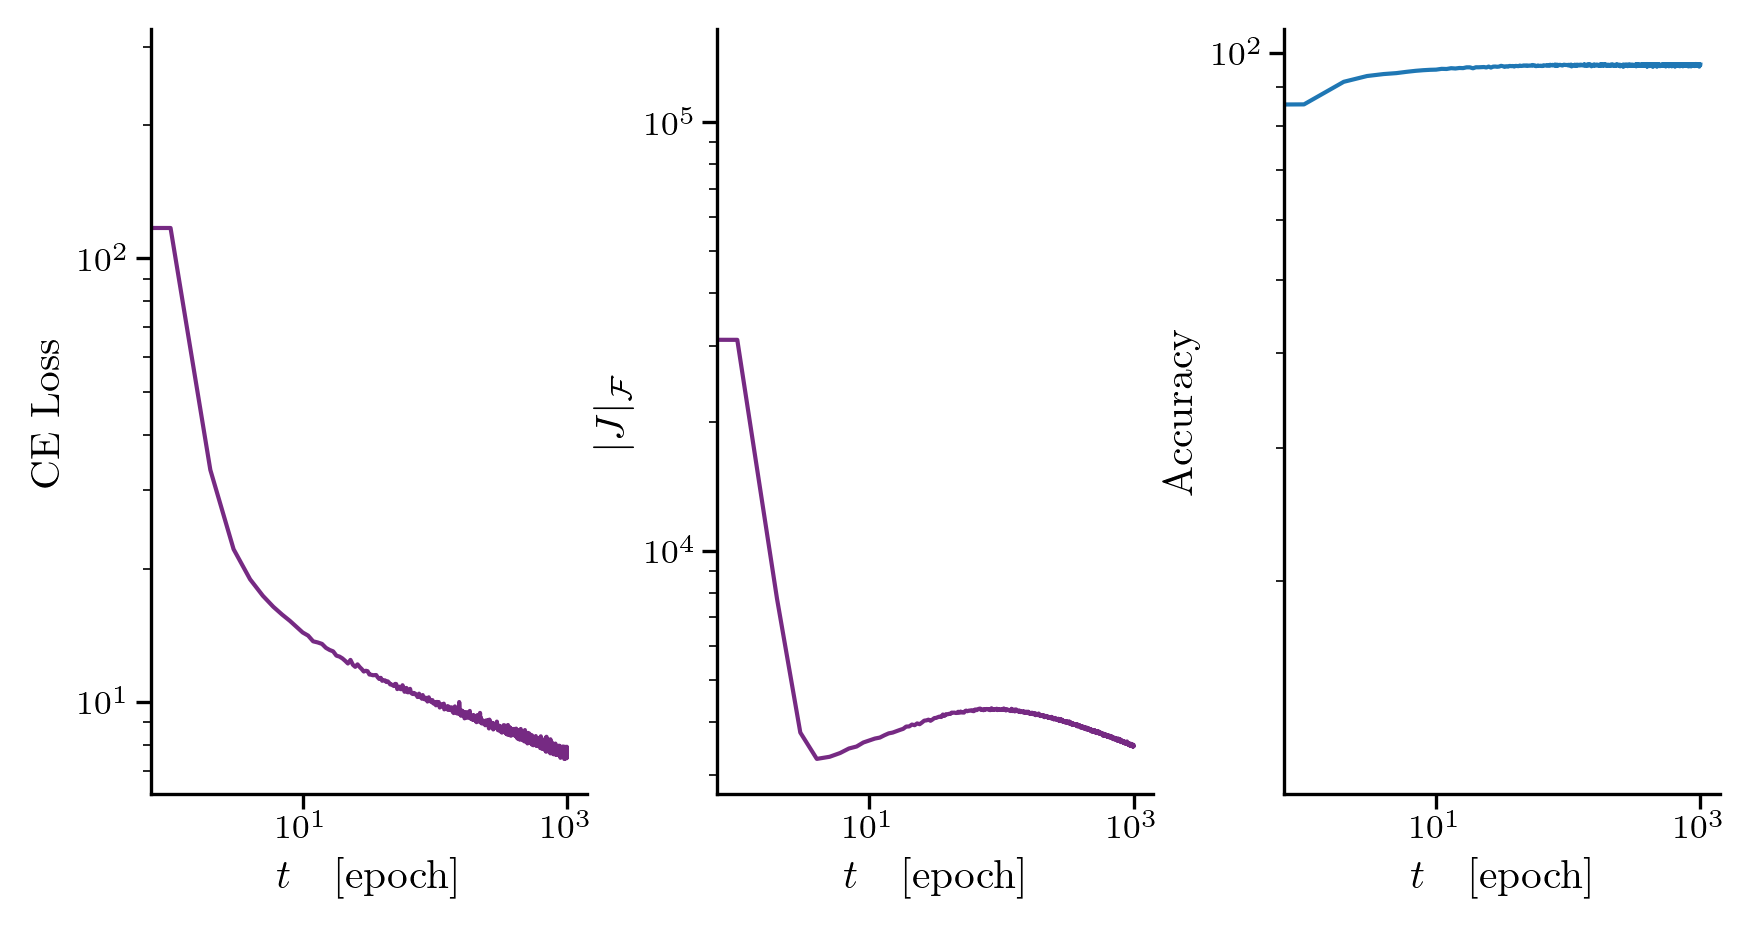

In [17]:
ce_loss, jf_loss = jfTrainer.get_training_history(mode="numpy")
accuracy, jf_score = jfTrainer.get_eval(mode="numpy")

fig, axs = plt.subplots(1, 3)
#n = np.arange(1, len(lambda_numpy)+1)
axs[0].loglog(ce_loss, color='#762a83')
axs[0].set_xlabel(r"$t \quad [\textrm{epoch}]$")
axs[0].set_ylabel(r"CE Loss")

axs[1].loglog(jf_loss, color='#762a83')
axs[1].set_xlabel(r"$t \quad [\textrm{epoch}]$")
axs[1].set_ylabel(r"$| J |_{\mathcal{F}}$")


axs[2].loglog(100*accuracy)
axs[2].set_xlabel(r"$t \quad [\textrm{epoch}]$")
axs[2].set_ylabel(r"Accuracy")

#spec_line = axs[2].loglog(n, lambda_numpy, color='#1b7837')
#norm_line = axs[2].loglog(n, lambda_numpy[tau]*n[tau] / n, color='#333333', linestyle=":")
#axs[2].set_xlabel(r"$n$")
#axs[2].set_ylabel(r"$\lambda_{n}$")
#axs[2].legend([r"$\lambda_{n}$", r"$1/n$"])
plt.show()

In [24]:
print("ce_loss: ", ce_loss[-1])
print("jf_loss: ", jf_loss[-1] / (len(dataloader_train)*BATCH_SIZE))
print("eval_acc: ", accuracy[-1])
print("jf_eval: ", jf_eval[-1] / (len(dataloader_test)*BATCH_SIZE))

ce_loss:  7.806799337267876
jf_loss:  0.058720254135131836
eval_acc:  0.964
jf_eval:  0.04611711273193359


60

In [18]:
@JFReg(alpha_JF=1e-3, n=1)
class JFTrainer(CETrainer):
    pass

In [19]:
jfTrainer_dec = JFTrainer(model_cpy, device, learning_rate=1e-3)
jfTrainer_dec.run(dataloader_train, dataloader_test, no_epochs=1000)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

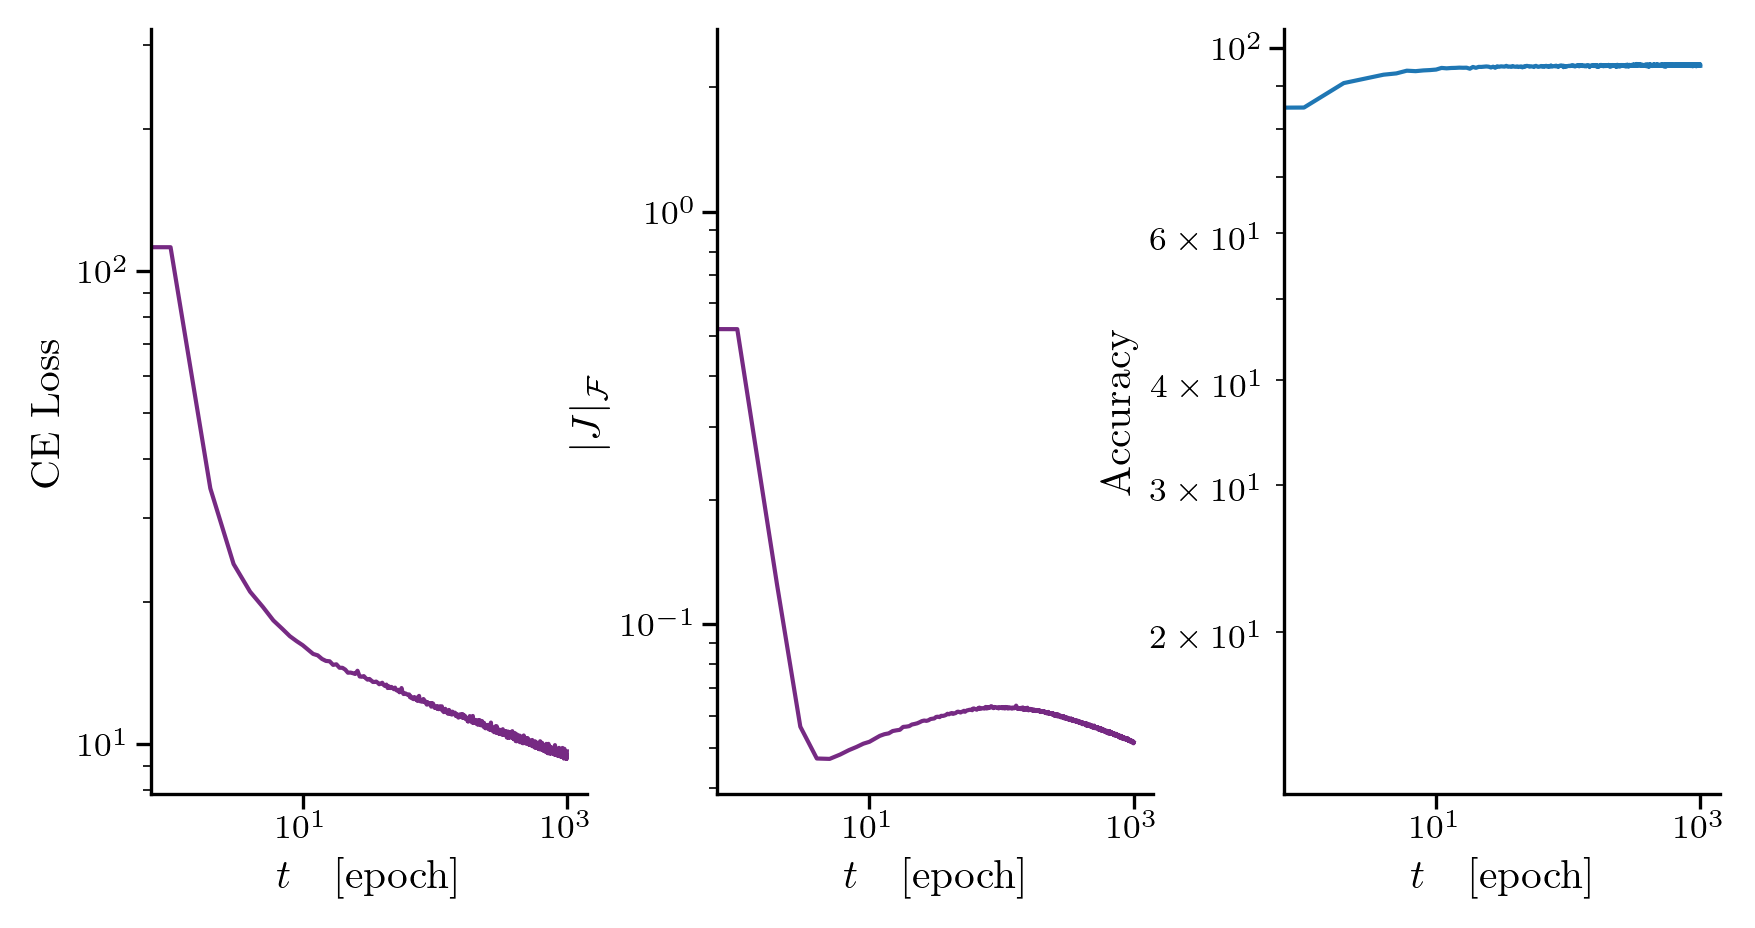

In [28]:
loss = np.array(jfTrainer_dec.log["loss"])
ce_loss = np.array(jfTrainer_dec.log["ce_loss"])
eval_acc = np.array(jfTrainer_dec.log["eval_acc"])
jf_loss = np.array(jfTrainer_dec.log["JFReg_loss"]) / (len(dataloader_train)*BATCH_SIZE)
jf_eval = np.array(jfTrainer_dec.log["eval_JFReg_score"]) / (len(dataloader_test)*BATCH_SIZE)


fig, axs = plt.subplots(1, 3)
#n = np.arange(1, len(lambda_numpy)+1)
axs[0].loglog(loss, color='#762a83')
axs[0].set_xlabel(r"$t \quad [\textrm{epoch}]$")
axs[0].set_ylabel(r"CE Loss")

axs[1].loglog(jf_loss, color='#762a83')
axs[1].set_xlabel(r"$t \quad [\textrm{epoch}]$")
axs[1].set_ylabel(r"$| J |_{\mathcal{F}}$")


axs[2].loglog(100*eval_acc)
axs[2].set_xlabel(r"$t \quad [\textrm{epoch}]$")
axs[2].set_ylabel(r"Accuracy")

#fig, axs = plt.subplots(1, 3)
#n = np.arange(1, len(lambda_numpy)+1)
#axs[0].loglog(loss, color='#762a83')
#axs[0].set_xlabel(r"$t \quad [\textrm{epoch}]$")
#axs[0].set_ylabel(r"Loss")

#axs[1].loglog(ce_loss, label="CE")#color='#762a83')
#axs[1].loglog(jf_loss, label="JF train")
#axs[1].loglog(jf_eval, label="JF eval")
#axs[1].set_xlabel(r"$t \quad [\textrm{epoch}]$")
#axs[1].set_ylabel(r"$Components$")
#axs[1].legend()


#axs[2].loglog(eval_acc, label="Acc")
#axs[2].set_xlabel(r"$t \quad [\textrm{epoch}]$")
#axs[2].set_ylabel(r"Accuracy")

#spec_line = axs[2].loglog(n, lambda_numpy, color='#1b7837')
#norm_line = axs[2].loglog(n, lambda_numpy[tau]*n[tau] / n, color='#333333', linestyle=":")
#axs[2].set_xlabel(r"$n$")
#axs[2].set_ylabel(r"$\lambda_{n}$")
#axs[2].legend([r"$\lambda_{n}$", r"$1/n$"])
plt.show()

In [30]:
print("ce_loss: ", ce_loss[-1])
print("jf_loss: ", jf_loss[-1])
print("eval_acc: ", eval_acc[-1])
print("jf_eval: ", jf_eval[-1])

ce_loss:  6.547735594213009
jf_loss:  0.051749664052327476
eval_acc:  0.9514
jf_eval:  0.05151059684753418
